# Sales Data Preprocessing for Azure ML AutoML Forecasting

This notebook prepares sales data for time series forecasting with Azure Machine Learning AutoML.

In [1]:
# Install required dependencies if not available
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = ['pandas', 'matplotlib', 'seaborn', 'numpy', 'statsmodels']
for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")

✓ pandas is already installed
✓ matplotlib is already installed
Installing seaborn...
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
✓ seaborn installed successfully
✓ numpy is already installed
Installing statsmodels...
✓ seaborn installed successfully
✓ numpy is already installed
Installing statsmodels...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/10.8 MB ? eta -:--:--Collecting statsmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 104.4 MB/s eta 0:00:00
✓ statsmodels installed successfully
✓ statsmodels installed successfully


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try to import seaborn but don't fail if it's not available
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    has_seaborn = True
except ImportError:
    has_seaborn = False
    print("Seaborn not available, falling back to basic matplotlib styling")
    plt.style.use('ggplot')

# Try to import statsmodels but don't fail if it's not available
try:
    import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
    has_statsmodels = True
except ImportError:
    has_statsmodels = False
    print("Statsmodels not available, seasonal decomposition will be skipped")

# Load the dataset
df = pd.read_csv('azureml://subscriptions/b43bf58b-22dc-4419-ae40-26f681e3cd05/resourcegroups/t-aml-1/workspaces/t-aml-ws-1/datastores/workspaceblobstore/paths/UI/2025-05-07_030032_UTC/Sales Data.csv')

Timeout was exceeded in force_flush().
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


## 1. Data Exploration

Let's first explore the loaded dataset to understand its structure.

In [3]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (185950, 13)

First 5 rows:


,Unnamed: 0,Order ID,Product Category,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Time of Day
0,0,295665,Laptops and Computers,Macbook Pro Laptop,1,1700.00,30-12-2019 00:01,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0,Night
1,1,295666,Home Appliances,LG Washing Machine,1,600.00,29-12-2019 07:03,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7,Morning
2,2,295667,Charging Cables,USB-C Charging Cable,1,11.95,12-12-2019 18:21,"277 Main St, New York City, NY 10001",12,11.95,New York City,18,Evening
3,3,295668,Monitors,27in FHD Monitor,1,149.99,22-12-2019 15:13,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15,Afternoon
4,4,295669,Charging Cables,USB-C Charging Cable,1,11.95,18-12-2019 12:38,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12,Afternoon


In [4]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        185950 non-null  int64  
 1   Order ID          185950 non-null  int64  
 2   Product Category  185950 non-null  object 
 3   Product           185950 non-null  object 
 4   Quantity Ordered  185950 non-null  int64  
 5   Price Each        185950 non-null  float64
 6   Order Date        185950 non-null  object 
 7   Purchase Address  185950 non-null  object 
 8   Month             185950 non-null  int64  
 9   Sales             185950 non-null  float64
 10  City              185950 non-null  object 
 11  Hour              185950 non-null  int64  
 12  Time of Day       185950 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 18.4+ MB


## 2. Data Cleaning and Preprocessing

Now we'll clean the data and prepare it for time series forecasting.

In [5]:
# Make a copy of the dataframe for preprocessing
df_clean = df.copy()

# Ensure Order Date is in datetime format
df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'])

# Extract time components for additional features
df_clean['Year'] = df_clean['Order Date'].dt.year
df_clean['Month'] = df_clean['Order Date'].dt.month
df_clean['Day'] = df_clean['Order Date'].dt.day
df_clean['Day of Week'] = df_clean['Order Date'].dt.dayofweek
df_clean['Quarter'] = df_clean['Order Date'].dt.quarter

# Check if there are any missing values
print("Missing values per column:")
print(df_clean.isnull().sum())

# Display the preprocessed dataframe
df_clean.head()

Missing values per column:
Unnamed: 0          0
Order ID            0
Product Category    0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
Month               0
Sales               0
City                0
Hour                0
Time of Day         0
Year                0
Day                 0
Day of Week         0
Quarter             0
dtype: int64


,Unnamed: 0,Order ID,Product Category,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Time of Day,Year,Day,Day of Week,Quarter
0,0,295665,Laptops and Computers,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0,Night,2019,30,0,4
1,1,295666,Home Appliances,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7,Morning,2019,29,6,4
2,2,295667,Charging Cables,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18,Evening,2019,12,3,4
3,3,295668,Monitors,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15,Afternoon,2019,22,6,4
4,4,295669,Charging Cables,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12,Afternoon,2019,18,2,4


## 3. Time Series Aggregation

For forecasting, we need to aggregate sales data by time periods (daily, weekly, monthly).

In [6]:
# Aggregate sales by day
daily_sales = df_clean.groupby(df_clean['Order Date'].dt.date)['Sales'].sum().reset_index()
daily_sales['Order Date'] = pd.to_datetime(daily_sales['Order Date'])

# Create a complete date range to account for missing days
min_date = daily_sales['Order Date'].min()
max_date = daily_sales['Order Date'].max()
date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Create a dataframe with the complete date range
complete_daily_sales = pd.DataFrame({'Order Date': date_range})

# Merge with our actual sales data
complete_daily_sales = complete_daily_sales.merge(daily_sales, on='Order Date', how='left')

# Fill missing values with 0
complete_daily_sales['Sales'] = complete_daily_sales['Sales'].fillna(0)

# Extract time features for the complete dataset
complete_daily_sales['Year'] = complete_daily_sales['Order Date'].dt.year
complete_daily_sales['Month'] = complete_daily_sales['Order Date'].dt.month
complete_daily_sales['Day'] = complete_daily_sales['Order Date'].dt.day
complete_daily_sales['Day of Week'] = complete_daily_sales['Order Date'].dt.dayofweek
complete_daily_sales['Quarter'] = complete_daily_sales['Order Date'].dt.quarter

# Display the aggregated daily sales
complete_daily_sales.head()

,Order Date,Sales,Year,Month,Day,Day of Week,Quarter
0,2019-01-01,65681.94,2019,1,1,1,1
1,2019-01-02,71757.33,2019,1,2,2,1
2,2019-01-03,90943.91,2019,1,3,3,1
3,2019-01-04,112697.76,2019,1,4,4,1
4,2019-01-05,107690.74,2019,1,5,5,1


In [7]:
# Create weekly and monthly aggregations
weekly_sales = complete_daily_sales.resample('W-Mon', on='Order Date')['Sales'].sum().reset_index()
monthly_sales = complete_daily_sales.resample('MS', on='Order Date')['Sales'].sum().reset_index()

# Display the first few rows of each
print("Weekly Sales:")
print(weekly_sales.head())
print("\nMonthly Sales:")
print(monthly_sales.head())

Weekly Sales:
  Order Date      Sales
0 2019-01-07  628809.28
1 2019-01-14  640214.55
2 2019-01-21  405794.71
3 2019-01-28  423103.35
4 2019-02-04  525827.30

Monthly Sales:
  Order Date       Sales
0 2019-01-01  2278235.84
1 2019-02-01  2394466.93
2 2019-03-01  2793085.44
3 2019-04-01  3229765.34
4 2019-05-01  3033275.77


## 4. Feature Engineering

Let's create additional features that might be helpful for forecasting.

In [8]:
# Add rolling statistics (7-day and 30-day moving averages)
complete_daily_sales['Sales_MA7'] = complete_daily_sales['Sales'].rolling(window=7, min_periods=1).mean()
complete_daily_sales['Sales_MA30'] = complete_daily_sales['Sales'].rolling(window=30, min_periods=1).mean()

# Create lag features (previous day, previous week)
complete_daily_sales['Sales_Lag1'] = complete_daily_sales['Sales'].shift(1)
complete_daily_sales['Sales_Lag7'] = complete_daily_sales['Sales'].shift(7)

# Create a weekend flag
complete_daily_sales['Is_Weekend'] = (complete_daily_sales['Day of Week'] >= 5).astype(int)

# Fill NaN values created by shift operations
complete_daily_sales = complete_daily_sales.fillna(0)

# Display the dataframe with new features
complete_daily_sales.head(10)

,Order Date,Sales,Year,Month,Day,Day of Week,Quarter,Sales_MA7,Sales_MA30,Sales_Lag1,Sales_Lag7,Is_Weekend
0,2019-01-01,65681.94,2019,1,1,1,1,65681.940000,65681.940000,0.00,0.00,0
1,2019-01-02,71757.33,2019,1,2,2,1,68719.635000,68719.635000,65681.94,0.00,0
2,2019-01-03,90943.91,2019,1,3,3,1,76127.726667,76127.726667,71757.33,0.00,0
3,2019-01-04,112697.76,2019,1,4,4,1,85270.235000,85270.235000,90943.91,0.00,0
4,2019-01-05,107690.74,2019,1,5,5,1,89754.336000,89754.336000,112697.76,0.00,1
5,2019-01-06,90536.69,2019,1,6,6,1,89884.728333,89884.728333,107690.74,0.00,1
6,2019-01-07,89500.91,2019,1,7,0,1,89829.897143,89829.897143,90536.69,0.00,0
7,2019-01-08,72168.44,2019,1,8,1,1,90756.540000,87622.215000,89500.91,65681.94,0
8,2019-01-09,67913.39,2019,1,9,2,1,90207.405714,85432.345556,72168.44,71757.33,0
9,2019-01-10,133545.32,2019,1,10,3,1,96293.321429,90243.643000,67913.39,90943.91,0


## 5. Data Visualization

Let's visualize the sales patterns to better understand the time series.

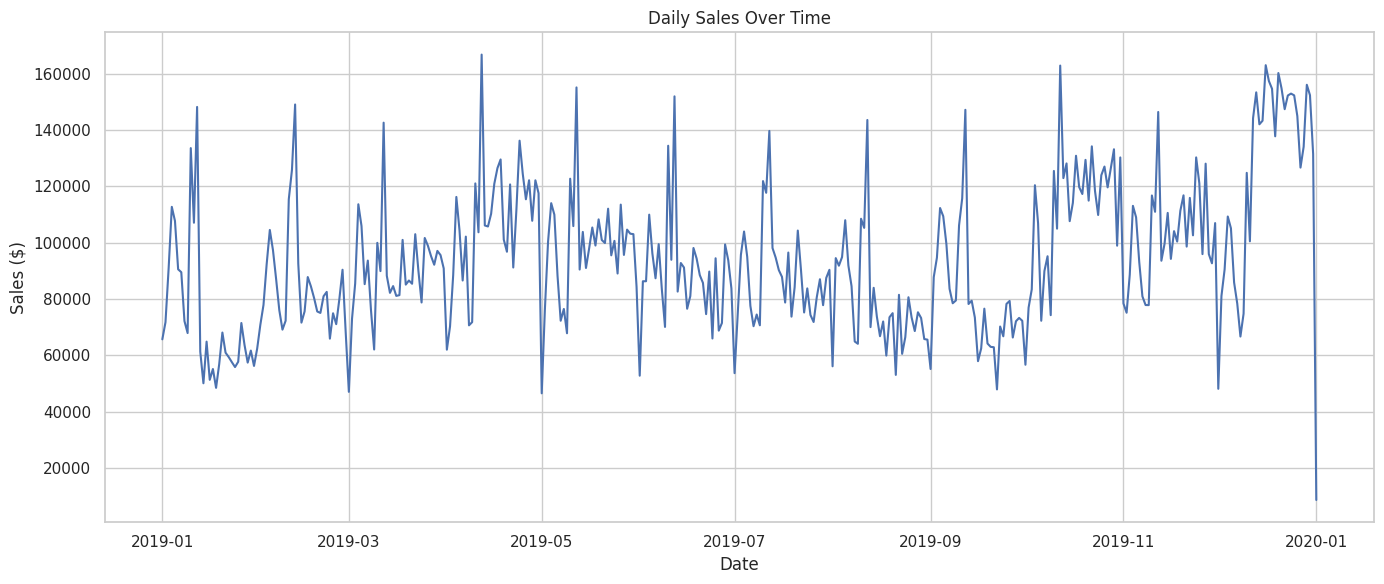

In [9]:
# Simple line plot of daily sales (works without seaborn)
plt.figure(figsize=(14, 6))
plt.plot(complete_daily_sales['Order Date'], complete_daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

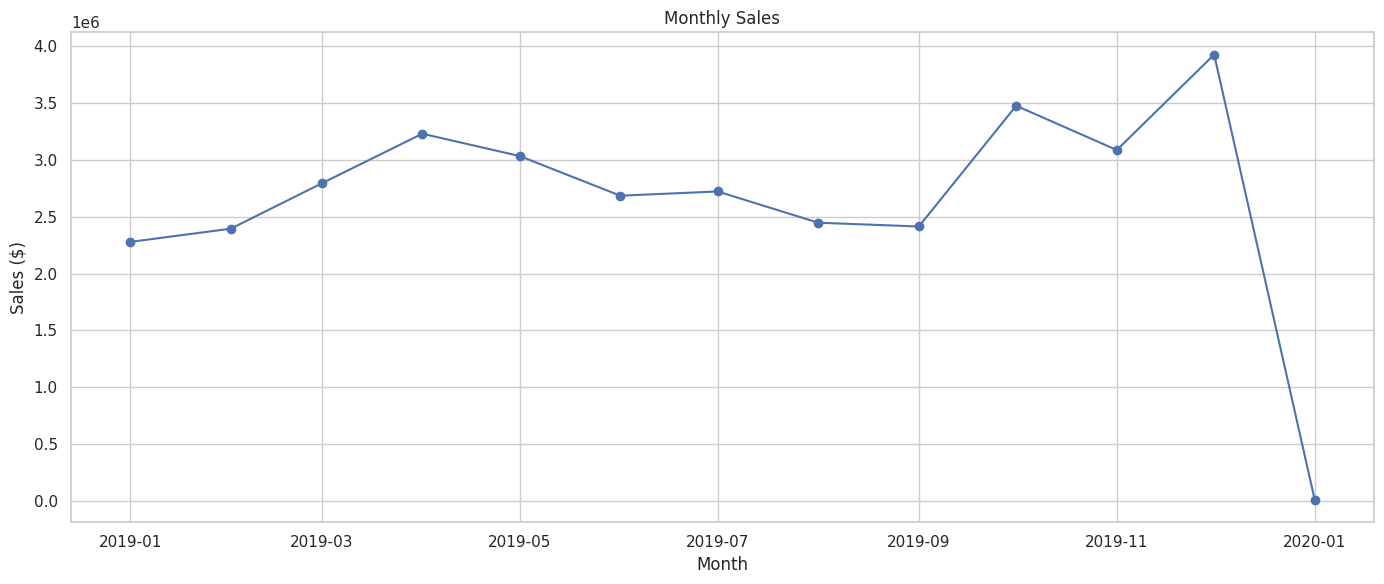

In [10]:
# Plot monthly sales (works without seaborn)
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

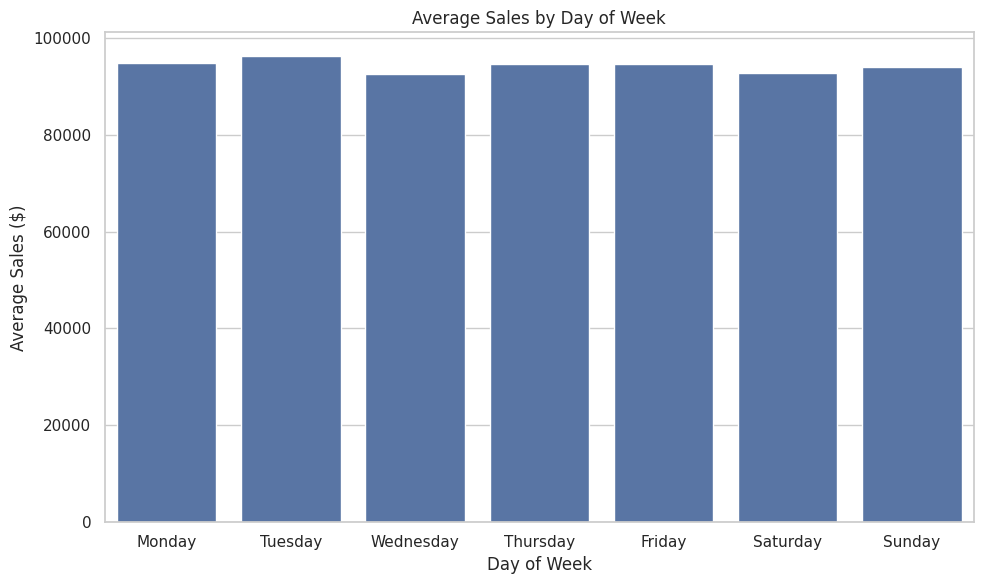

In [11]:
# Analyze sales by day of week (with conditional use of seaborn)
day_of_week_sales = complete_daily_sales.groupby('Day of Week')['Sales'].mean().reset_index()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_sales['Day Name'] = day_of_week_sales['Day of Week'].apply(lambda x: day_names[int(x)])

plt.figure(figsize=(10, 6))
if has_seaborn:
    sns.barplot(x='Day Name', y='Sales', data=day_of_week_sales)
else:
    # Fallback to basic matplotlib if seaborn is not available
    plt.bar(day_of_week_sales['Day Name'], day_of_week_sales['Sales'])

plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales ($)')
plt.tight_layout()
plt.show()

## 6. Prepare Data for Azure ML AutoML

Now we'll prepare the final dataset structure for Azure ML AutoML forecasting.

In [12]:
# For AutoML time-series forecasting, we need data in a specific format
# Typically we need a time column and target column (Sales)

# We'll use the daily aggregated data
automl_data = complete_daily_sales[['Order Date', 'Sales', 'Year', 'Month', 'Day', 'Day of Week', 'Is_Weekend',
                                  'Sales_MA7', 'Sales_MA30', 'Sales_Lag1', 'Sales_Lag7']].copy()

# Rename columns to match AutoML requirements
automl_data = automl_data.rename(columns={'Order Date': 'time', 'Sales': 'y'})

# Display the first few rows of the prepared dataset
automl_data.head()

,time,y,Year,Month,Day,Day of Week,Is_Weekend,Sales_MA7,Sales_MA30,Sales_Lag1,Sales_Lag7
0,2019-01-01,65681.94,2019,1,1,1,0,65681.940000,65681.940000,0.00,0.0
1,2019-01-02,71757.33,2019,1,2,2,0,68719.635000,68719.635000,65681.94,0.0
2,2019-01-03,90943.91,2019,1,3,3,0,76127.726667,76127.726667,71757.33,0.0
3,2019-01-04,112697.76,2019,1,4,4,0,85270.235000,85270.235000,90943.91,0.0
4,2019-01-05,107690.74,2019,1,5,5,1,89754.336000,89754.336000,112697.76,0.0


In [13]:
# Save the processed data for Azure ML AutoML
automl_data.to_csv('sales_forecasting_data.csv', index=False)
print("Data saved to 'sales_forecasting_data.csv' and is ready for Azure ML AutoML forecasting.")

# Display the final processed dataset
automl_data

Data saved to 'sales_forecasting_data.csv' and is ready for Azure ML AutoML forecasting.


,time,y,Year,Month,Day,Day of Week,Is_Weekend,Sales_MA7,Sales_MA30,Sales_Lag1,Sales_Lag7
0,2019-01-01,65681.94,2019,1,1,1,0,65681.940000,65681.940000,0.00,0.00
1,2019-01-02,71757.33,2019,1,2,2,0,68719.635000,68719.635000,65681.94,0.00
2,2019-01-03,90943.91,2019,1,3,3,0,76127.726667,76127.726667,71757.33,0.00
3,2019-01-04,112697.76,2019,1,4,4,0,85270.235000,85270.235000,90943.91,0.00
4,2019-01-05,107690.74,2019,1,5,5,1,89754.336000,89754.336000,112697.76,0.00
...,...,...,...,...,...,...,...,...,...,...,...
361,2019-12-28,134015.50,2019,12,28,5,1,144325.050000,122840.374667,126628.05,154756.87
362,2019-12-29,156024.62,2019,12,29,6,1,145564.554286,124952.313667,134015.50,147348.09
363,2019-12-30,152319.81,2019,12,30,0,0,145579.605714,126465.084667,156024.62,152214.45
364,2019-12-31,131454.30,2019,12,31,1,0,142517.531429,129242.681000,152319.81,152888.82


## 7. Decomposition Analysis (Optional)

We can also perform time series decomposition to understand seasonal patterns.

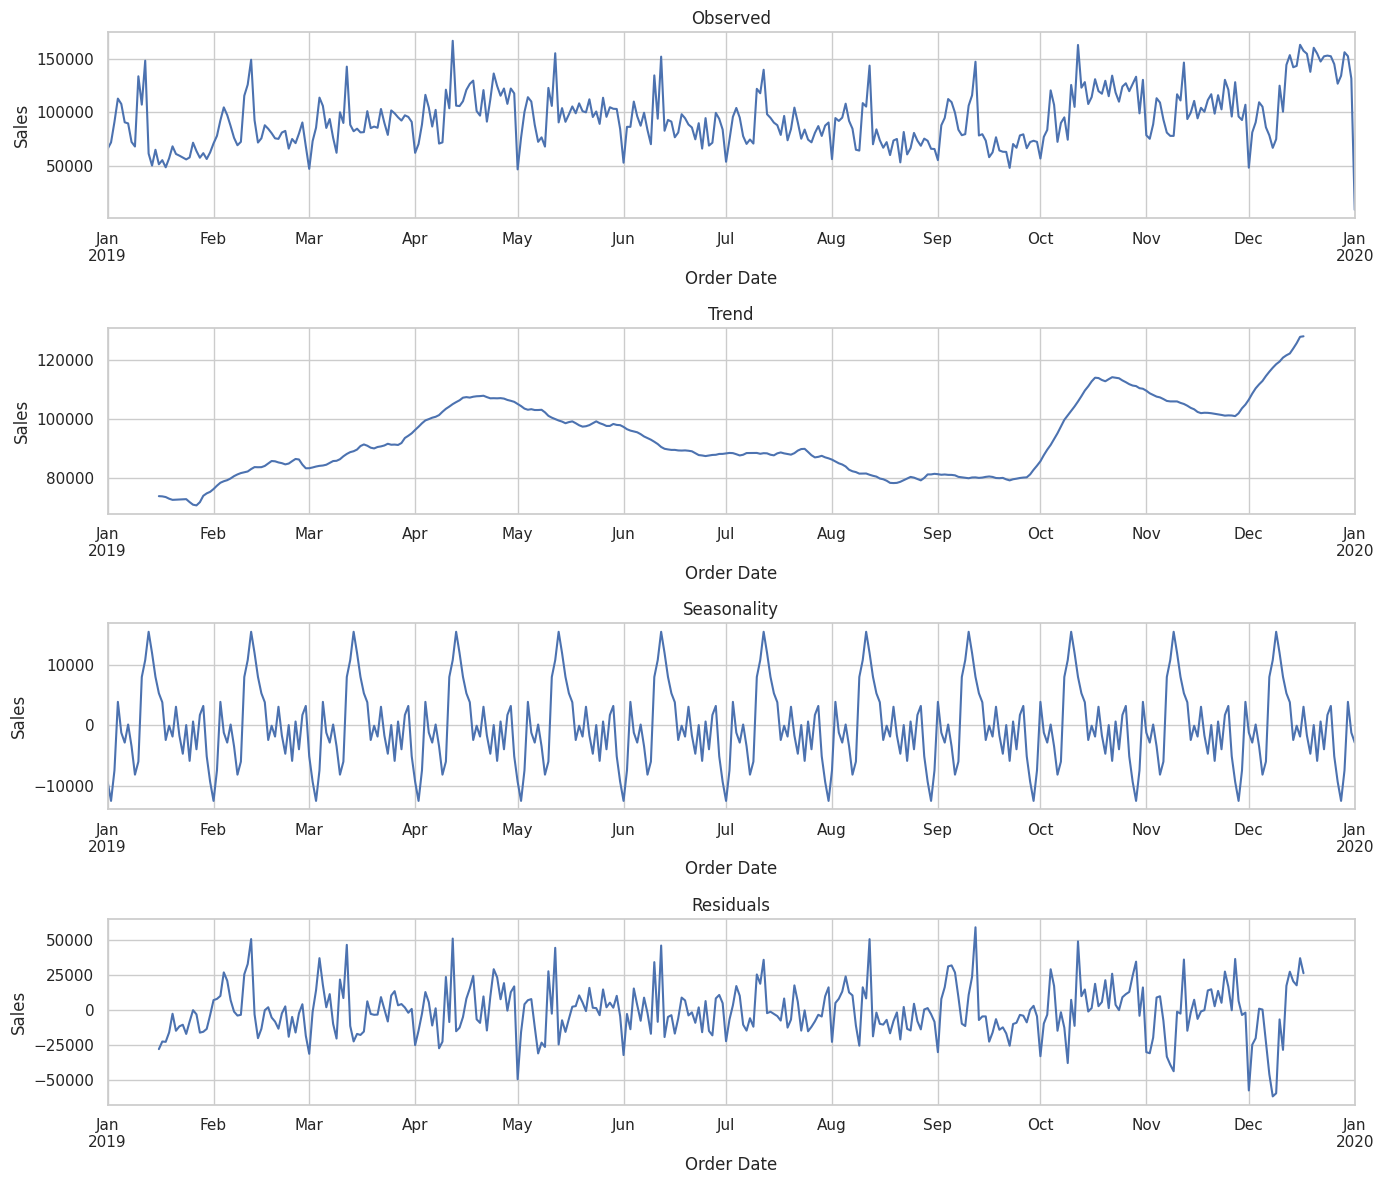

In [15]:
# Only run decomposition if statsmodels is available
if has_statsmodels:
    # Set the index to datetime for decomposition
    ts_data = complete_daily_sales.set_index('Order Date')['Sales']
    
    # Ensure we have enough data points for decomposition
    if len(ts_data) > 14:  # Need at least 2 weeks of data
        # Perform seasonal decomposition
        decomposition = seasonal_decompose(ts_data, model='additive', period=30)  # 7-day seasonality
        
        # Plot the decomposition
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
        
        decomposition.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        ax1.set_ylabel('Sales')
        
        decomposition.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        ax2.set_ylabel('Sales')
        
        decomposition.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonality')
        ax3.set_ylabel('Sales')
        
        decomposition.resid.plot(ax=ax4)
        ax4.set_title('Residuals')
        ax4.set_ylabel('Sales')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for seasonal decomposition. Need at least 14 days of data.")
else:
    print("Statsmodels is not available. Skipping seasonal decomposition.")